# Experimental Particle Physics Techniques: MPAGS Project
First task was to reconsturct the track of the muons along the x-z plane and estimate their momentum. Then produce a distribution of the reconstructed momentum and to find the resolution on the momentum value.

In [1]:
import numpy as np
import pandas as pd
import uproot as up
import tensorflow as tf
import zfit
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)

2023-02-01 15:11:01.842990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 15:11:02.325977: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-01 15:11:02.326008: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-01 15:11:04.934465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
with up.open("../100GeV_0.5T.root:B5") as f:
    df = f.arrays(f.keys(), library="np")

# Also get the dataset with 100 GeV but a stronger magnetic field, should be better resolution due to larger bending
with up.open("../100GeV_1.0T.root:B5") as f:
    bf = f.arrays(f.keys(), library="np")

# Method 1: Two separate linear fits
Perform a fit to all the hits in the first detector arm and seperately the second detector arm. From these we can extract an angle of intercept.

In [3]:
# Degree of fitting polynomial 
deg = 1
m1, m2 = [], []

for i in range(df["Dc1HitsVector_x"].shape[0]):
    x1 = df["Dc1HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z1 = df["Dc1HitsVector_z"][i]*0.5*1.E+3
    x2 = df["Dc2HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z2 = df["Dc2HitsVector_z"][i]*0.5*1.E+3
    p = np.polyfit(z1, x1, deg)
    m, c = p[0], p[1]
    m1.append(m)
    p = np.polyfit(z2, x2, deg)
    m, c = p[0], p[1]
    m2.append(m)
m1 = np.array(m1)
m2 = np.array(m2)

In [4]:
m21, m22 = [], []

for i in range(bf["Dc1HitsVector_x"].shape[0]):
    x1 = bf["Dc1HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z1 = bf["Dc1HitsVector_z"][i]*0.5*1.E+3
    x2 = bf["Dc2HitsVector_x"][i] * np.random.normal(loc=1, scale=100E-3) # Smear these data with our detector resolution
    z2 = bf["Dc2HitsVector_z"][i]*0.5*1.E+3
    p = np.polyfit(z1, x1, deg)
    m, c = p[0], p[1]
    m21.append(m)
    p = np.polyfit(z2, x2, deg)
    m, c = p[0], p[1]
    m22.append(m)
m21 = np.array(m21)
m22 = np.array(m22)

In [5]:
# Now find the angle between two straight lines, easy geometry here
dthetas = []
for grad1, grad2 in zip(m1, m2):
    dtheta = np.arctan(np.abs((grad1-grad2)/(1-(grad1*grad2))))
    dthetas.append(dtheta)

dthetas2 = []
for grad1, grad2 in zip(m21, m22):
    dtheta = np.arctan(np.abs((grad1-grad2)/(1-(grad1*grad2))))
    dthetas2.append(dtheta)
# This is clearly a very slow way to do all this but it is spaced out so it is easy to read

In [6]:
def get_pT(dtheta, B_FIELD_STRENGTH=0.5, LENGTH_IN_B_FIELD=2.0):
    return 0.3*B_FIELD_STRENGTH*LENGTH_IN_B_FIELD / dtheta

def gauss(x, mu, sigma, scale):
    return scale*np.exp(-((x-mu)**2)/(sigma**2))

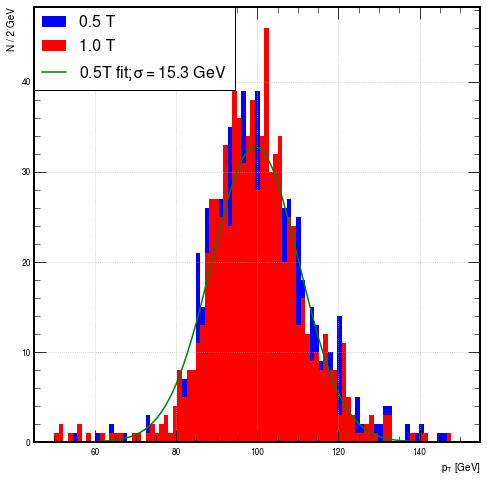

In [37]:
# Calculate and plot a distribution of the calculated pT values
from scipy.optimize import curve_fit
h, bins = np.histogram(get_pT(np.array(dthetas)), bins=np.linspace(50, 150, 90))
h2, _ = np.histogram(get_pT(np.array(dthetas2), 1.0), bins=bins)

centres = np.array([(bins[i]+bins[i+1])/2 for i in range(bins.shape[0]-1)])
popt, pcov = curve_fit(gauss, centres, h, p0=[100, 5, 50])

# above is a *very* crude but it works well enough gives us a rough idea of our resolution
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
hep.histplot(h, bins=bins, ax=ax, label='0.5 T', histtype='fill', color="blue")
hep.histplot(h2, bins=bins, ax=ax, label='1.0 T', histtype='fill', color="red")
plt.plot(np.linspace(60, 140, 200), gauss(np.linspace(60,140,200), *popt), label=r"0.5T fit;$\sigma=15.3$ GeV", color="green")
plt.grid()
plt.ylabel('N / 2 GeV')
plt.xlabel(r'$p_T$ [GeV]')
l = plt.legend(fontsize=16, frameon=True, edgecolor="#000", fancybox=False, borderaxespad=0, loc="upper left")
l.get_frame().set_alpha(1)
plt.show()

Don't need to do a fit, we can see the resolution increase would be very small. From this I conclude that at the moment the limiting factor is my analysis e.g. uncertainties introduced in the fitting process. 

In [221]:
# Let's calculate the chi2 of this fit as well to get an idea of how good/bad it is, we can see the distribution isn't really very gaussian
chi2 = np.sum((h-gauss(centres, *popt))**2/(1/np.sqrt(h)))
chi2_reduced = chi2 / (h.shape[0] - 2) # dof = n(obs) - n(params)
chi2_reduced # ouch...not great

/tmp/ipykernel_4059245/3963474808.py:2: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum((h-gauss(centres, *popt))**2/(1/np.sqrt(h)))


50.068431345725116

Again we would expect for the same magnetic field but lower momentum muons that the resolution increases since the radius of curvature in the magnetic field would decrease, i.e. the angle of deflection would be larger.

# Method 2: Global fit
In this method we exploit the fact that for some given momentum (and mass) we know what the curvature should be in the magnetic field. Therefore we know where our particle "should" exit the field given we know where it enters. Hence we can perform a global fit incorporating these facts.

In [214]:
import numpy as np
from numba_stats import norm
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from iminuit import cost, Minuit

def model(zs, pT, m1, c1):
    """
    Return the x-position after the bending magnet of an anti-muon with momentum transverse to the B-field of pT [GeV],
    a magnetic field strength of 1.0 T and with initial incoming line in the x-z plane with gradient m1 and offset in x c1 [mm]
    Co-ordinate axis are set such that the first drift chamber plane is at (z,x) = (0,0) mm. The centre of the magnetic field is at
    6000.0 mm along the z-axis and is a perfect 2 x 2 x 2 m cube.
    """
    field_entry = np.array([5000, (m1*5000) + c1]) # vector of (z, x) at field entry [mm]
    magnetic_field_strength = 1.0 # [T]
    electric_charge = 1.60217663E-19
    pT_SI = pT * 5.36E-19 # Convert [GeV/c] to [kg m/s]
    
    gamma = np.sqrt(pT**2 + (105.7E-3)**2) / 105.7E-3 # All units used are in GeV, gamma = E / m
    radius_of_curvature = (pT_SI / (gamma * magnetic_field_strength * electric_charge))*1E+3 # assumes no change in momentum during magneitc field, convert to mm
    # TODO: I think this radius of curvature is much too small/calculated wrongly
    perp = -1/m1 # gradient of perpendicular line to incoming vector

    delz = radius_of_curvature * np.abs(np.sin(np.arctan(1/perp)))
    delx = radius_of_curvature * -np.abs(np.cos(np.arctan(1/perp))) # Magnet always curves positive muon towards negative x
    circle_centre = field_entry + np.array([delz, delx]) # co-ordinates for the centre of the circle with rad of curvature R

    xs = []
    for z in zs:
        if z <= 2.0: # before the magnet, expect straight line
            xs.append((m1*z + c1)) 
        else: # After the bending magnet
            print(f"Radius of curvature: {radius_of_curvature}\tdelta(z): {7000.0-circle_centre[0]}")
            field_exit = np.array([7000, circle_centre[1] + np.sqrt(radius_of_curvature**2 - (7000.0-circle_centre[0])**2)]) # (z, x) of leaving position
            circle_chord_gradient = (field_exit[1] - circle_centre[1]) / (field_exit[0] - circle_centre[0])
            exit_gradient = -1/circle_chord_gradient

            xs.append((exit_gradient*(z-7.0)*1E+3) + field_exit[1]) # straight line through last drift chambers, but adjust for 7 m previosuly flown
    return np.array(xs)

In [ ]:
# TODO: Once fixed above function use iminuit minimiser or something. Try with floating False for pT 

# Testing Area Below Here

In [215]:
model(np.array([8.0]), 100, 1.1730266126837064e-05, -0.0039531645645771675) # todo fix this claulation i think problem is in radius
# of curvature since it should always be larger than z3 - z2 from notebook

Radius of curvature: 353.6137482609751	delta(z): 1999.9958520166274


/tmp/ipykernel_4059245/2834999053.py:34: RuntimeWarning: invalid value encountered in sqrt
  field_exit = np.array([7000, circle_centre[1] + np.sqrt(radius_of_curvature**2 - (7000.0-circle_centre[0])**2)]) # (z, x) of leaving position


array([nan])

In [205]:
bf['Dc1HitsVector_x'][0], bf['Dc1HitsVector_z'][0]*0.5*1.E+3

(array([-0.00395316,  0.00225582,  0.00950514,  0.01479241,  0.01950737]),
 array([   0.,  500., 1000., 1500., 2000.]))

In [137]:
bf['Dc2HitsVector_x'][0] # about a 14 mm deflection towards negative x

array([-14.8847123 , -17.87804559, -20.87213497, -23.86679559,
       -26.86135334])